In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [203]:
raw_data = pd.read_csv('generated_values2years.csv')
df = raw_data.copy()

In [204]:
df.columns

Index(['fin_record_key', 'fin_debit_credit_ind', 'fin_company_id',
       'fin_trans_dt', 'fin_source_amt', 'fin_acct_num'],
      dtype='object')

In [205]:
df.drop(['fin_record_key','fin_debit_credit_ind','fin_acct_num','fin_company_id'],axis=1,inplace=True)

In [206]:
df.head()

,fin_trans_dt,fin_source_amt
0,2024-06-21,179.73
1,2024-11-25,450.87
2,2024-09-05,238.07
3,2024-06-30,210.59
4,2024-09-10,283.52


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fin_trans_dt    2000 non-null   object 
 1   fin_source_amt  2000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 31.4+ KB


In [208]:
df = df.groupby(df['fin_trans_dt']).agg({'fin_source_amt': 'mean'}).rename(columns={'fin_source_amt': 'Mean_amt'}).reset_index()

In [209]:
df['fin_trans_dt'] = pd.to_datetime(df['fin_trans_dt'])

In [210]:
df = df.sort_values('fin_trans_dt')

In [211]:
df.set_index('fin_trans_dt',inplace=True)

In [212]:
# Date features
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year

In [213]:
# Lag features (e.g., lag 1, lag 7)
df['lag_1'] = df['Mean_amt'].shift(1)
df['lag_7'] = df['Mean_amt'].shift(7)
df['lag_20'] = df['Mean_amt'].shift(20)
df['lag_40'] = df['Mean_amt'].shift(40)
df['lag_60'] = df['Mean_amt'].shift(60)

In [214]:
# Rolling statistics
df['rolling_mean_7'] = df['Mean_amt'].rolling(window=7).mean()
df['rolling_mean_30'] = df['Mean_amt'].rolling(window=30).mean()
df['rolling_mean_60'] = df['Mean_amt'].rolling(window=60).mean()

In [215]:
# Fill missing values with 0
df = df.fillna(0)

In [216]:
df.isna().sum()

Mean_amt           0
day_of_week        0
month              0
quarter            0
year               0
lag_1              0
lag_7              0
lag_20             0
lag_40             0
lag_60             0
rolling_mean_7     0
rolling_mean_30    0
rolling_mean_60    0
dtype: int64

In [217]:
#Splitting data
df_train,df_test = df.loc[:"2025-06-30"],df.loc["2025-07-01":]

In [218]:
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA

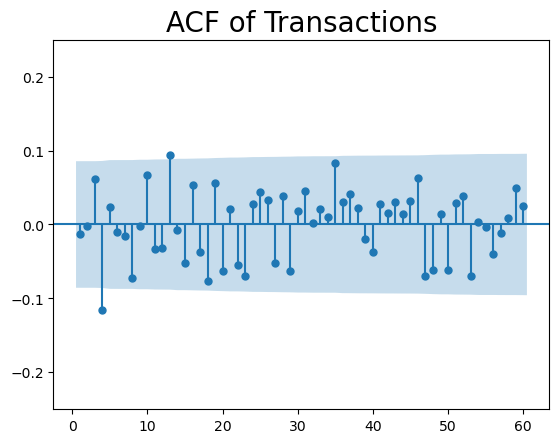

In [219]:
sgt.plot_acf(df_train['Mean_amt'],zero=False,lags=60)
plt.title('ACF of Transactions',size=20)
plt.ylim(-0.25,0.25)
plt.show()

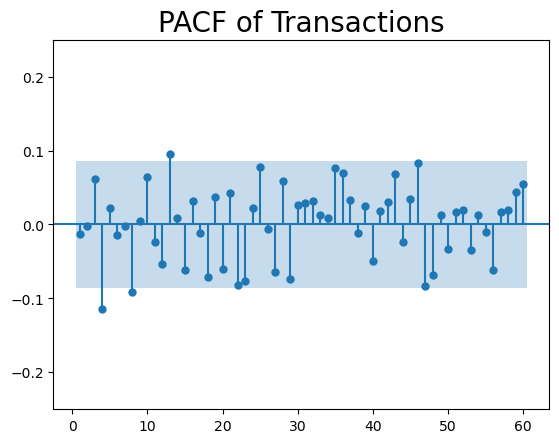

In [220]:
sgt.plot_pacf(df_train['Mean_amt'],zero=False,lags=60,method='ols')
plt.title('PACF of Transactions',size=20)
plt.ylim(-0.25,0.25)
plt.show()

In [221]:
sts.adfuller(df_train['Mean_amt'])

(-12.208946735891159,
 1.1758370174142064e-22,
 3,
 520,
 {'1%': -3.4429882202506255,
  '5%': -2.8671142122781066,
  '10%': -2.569738849852071},
 6068.988130309349)

In [255]:
#ARIMAX(1,1,1)

#set start and end date

start_date = '2025-07-01'
end_date = '2025-12-31'

model = ARIMA(df_train['Mean_amt'],order=(8,0,13) ,exog=df_train[['day_of_week', 'month', 'quarter','lag_1','lag_7' ,'lag_20', 'lag_40','lag_60', 'rolling_mean_7', 'rolling_mean_30','rolling_mean_60']])
results = model.fit()
print(results.summary())

df_pred = results.predict(start=len(df_train),end=len(df_train)+len(df_test)-1 ,exog=df_test[['day_of_week', 'month', 'quarter','lag_1','lag_7' ,'lag_20', 'lag_40','lag_60', 'rolling_mean_7', 'rolling_mean_30','rolling_mean_60']])
#                          ,'lag_1','lag_7' , 'lag_20', 'lag_40','lag_60',
#        'rolling_mean_7', 'rolling_mean_30','rolling_mean_60'



D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

                               SARIMAX Results                                
Dep. Variable:               Mean_amt   No. Observations:                  524
Model:                ARIMA(8, 0, 13)   Log Likelihood               -3054.697
Date:                Wed, 20 Mar 2024   AIC                           6177.393
Time:                        15:21:25   BIC                           6322.284
Sample:                             0   HQIC                          6234.134
                                - 524                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             165.4700     25.133      6.584      0.000     116.211     214.729
day_of_week        -1.1717      1.860     -0.630      0.529      -4.817       2.474
month               2.6990      

D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [256]:
predictions = pd.DataFrame(df_pred.values,index=df_test.index,columns=['Pred_Mean_amt'])

In [257]:
predictions

,Pred_Mean_amt
fin_trans_dt,
2025-07-01,241.955760
2025-07-02,259.344767
2025-07-03,281.036510
2025-07-05,258.291120
2025-07-06,214.851726
...,...
2025-12-27,317.208907
2025-12-28,64.497187
2025-12-29,415.002492


In [258]:
cmp = pd.concat([df_test['Mean_amt'],predictions],axis=1)

In [259]:
cmp.head(50)

,Mean_amt,Pred_Mean_amt
fin_trans_dt,,
2025-07-01,219.890000,241.955760
2025-07-02,215.586667,259.344767
2025-07-03,238.033333,281.036510
2025-07-05,265.590000,258.291120
2025-07-06,239.557500,214.851726
2025-07-07,295.820000,221.716698
2025-07-08,181.623333,176.343961
2025-07-09,380.530000,288.959073
2025-07-10,323.140000,223.470783


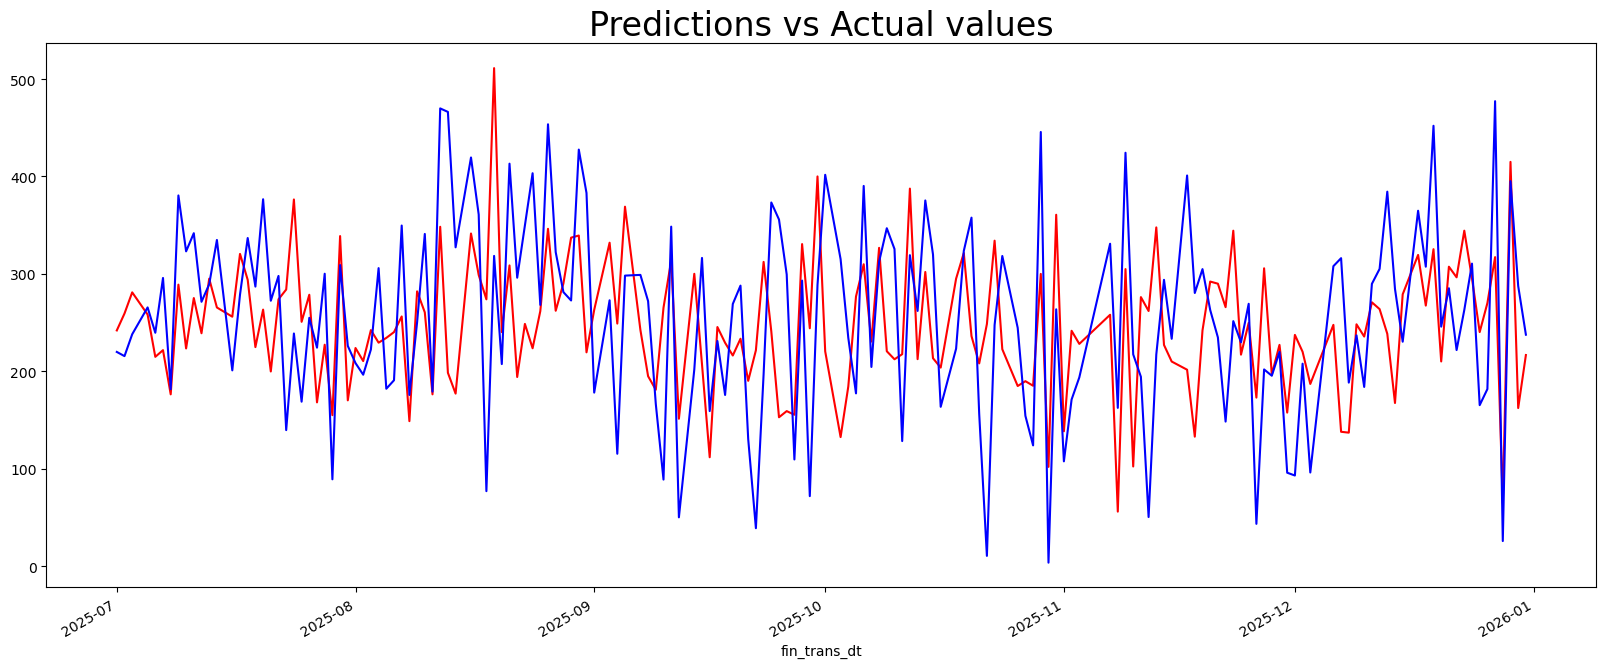

In [260]:
cmp['Pred_Mean_amt'].plot(figsize=(20,8),color="red")
cmp['Mean_amt'].plot(color="blue")
plt.title("Predictions vs Actual values",size=24)
plt.show()

In [261]:
print('RMSE:',np.sqrt(mean_squared_error(cmp['Mean_amt'],cmp['Pred_Mean_amt'])))

RMSE: 94.78072274227472


In [230]:
start_date = "2026-01-01"
end_date = "2026-06-30"

In [117]:
# # # Calculate lag1 and lag7 values
# # last_date = df.index[-1]
# # lag1_value = df.loc[last_date, 'Sum_amt']
# # lag7_value = df.loc[last_date - pd.DateOffset(days=7), 'Sum_amt']

# # # Calculate rolling_mean_7 and rolling_mean_30 values
# # rolling_mean_7_value = df['Sum_amt'].rolling(window=7).mean().iloc[-1]
# # rolling_mean_30_value = df['Sum_amt'].rolling(window=30).mean().iloc[-1]

# # Generate a date range for the forecast period
# forecast_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# # Create a DataFrame with the forecast dates
# df_forecast = pd.DataFrame(index=forecast_dates,columns=['day_of_week', 'month', 'quarter', 'year', 'lag_1', 'lag_7',
#        'rolling_mean_7', 'rolling_mean_30'])

# # Add the date features to the forecast DataFrame
# df_forecast['day_of_week'] = df_forecast.index.dayofweek
# df_forecast['month'] = df_forecast.index.month
# df_forecast['quarter'] = df_forecast.index.quarter
# df_forecast['year'] = df_forecast.index.year

# # Calculate lag1 and lag7 values
# last_date = df.index[-1]
# lag1_value = df.loc[last_date, 'Sum_amt']
# lag7_value = df.loc[last_date - pd.DateOffset(days=7), 'Sum_amt']

# # Calculate rolling_mean_7 and rolling_mean_30 values
# rolling_mean_7_value = df['Sum_amt'].rolling(window=7).mean().iloc[-1]
# rolling_mean_30_value = df['Sum_amt'].rolling(window=30).mean().iloc[-1]

# # Fill in NaN values in df_forecast with the calculated values
# df_forecast['lag_1'] = df_forecast['lag_1'].fillna(lag1_value)
# df_forecast['lag_7'] = df_forecast['lag_7'].fillna(lag7_value)
# df_forecast['rolling_mean_7'] = df_forecast['rolling_mean_7'].fillna(rolling_mean_7_value)
# df_forecast['rolling_mean_30'] = df_forecast['rolling_mean_30'].fillna(rolling_mean_30_value)

# model_1 = ARIMA(df['Sum_amt'],order=(34,0,34),exog=df[['day_of_week', 'month', 'quarter',
#                                                                  'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30']])
# results_1 = model_1.fit()
# print(results_1.summary())

# # Use the ARIMAX model to forecast
# forecast_values = results_1.predict(start=len(df), end=len(df)+len(df_forecast)-1,exog=df_forecast[['day_of_week', 'month', 'quarter',
#                                                                  'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_30']])

# # Plot the forecasted values
# plt.figure(figsize=(20, 5))
# plt.plot(forecast_values, color="green", label="Forecasted Values")
# plt.title("Forecasted Values for Sum_amt", size=24)
# plt.legend()
# plt.show()


D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Users\sharesh\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

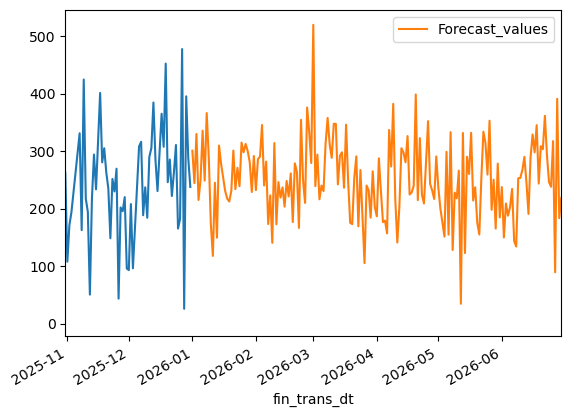

In [264]:
# Forecasting with the best order and exogenous variables
model = ARIMA(df['Mean_amt'], order=(8,0,13),exog=df[['day_of_week', 'month', 'quarter','lag_1','lag_7' ,'lag_20', 'lag_40','lag_60',
       'rolling_mean_7', 'rolling_mean_30','rolling_mean_60']])
results = model.fit()

start_date = "2026-01-01"
end_date = "2026-06-30"

forecast_dates = pd.date_range(start=start_date, end=end_date, freq='D')

df_forecast = pd.DataFrame(index=forecast_dates, columns=['day_of_week', 'month', 'quarter','lag_1','lag_7' ,'lag_20', 'lag_40','lag_60',
       'rolling_mean_7', 'rolling_mean_30','rolling_mean_60'])

# df_forecast['day_of_week'] = df_forecast.index.to_series().dt.dayofweek
# df_forecast['month'] = df_forecast.index.to_series().dt.month
# df_forecast['quarter'] = df_forecast.index.to_series().dt.quarter
# df_forecast['year'] = df_forecast.index.to_series().dt.year

# # Calculate lag_60, lag_120, lag_180 for each forecasted date
# for date in df_forecast.index:
#     df_forecast.loc[date, 'lag_1'] = df.loc[date - pd.DateOffset(days=1), 'Mean_amt'] if date - pd.DateOffset(days=1) in df.index else 0
#     df_forecast.loc[date, 'lag_7'] = df.loc[date - pd.DateOffset(days=7), 'Mean_amt'] if date - pd.DateOffset(days=7) in df.index else 0
#     df_forecast.loc[date, 'lag_20'] = df.loc[date - pd.DateOffset(days=20), 'Mean_amt'] if date - pd.DateOffset(days=20) in df.index else 0
#     df_forecast.loc[date, 'lag_40'] = df.loc[date - pd.DateOffset(days=40), 'Mean_amt'] if date - pd.DateOffset(days=40) in df.index else 0
#     df_forecast.loc[date, 'lag_60'] = df.loc[date - pd.DateOffset(days=60), 'Mean_amt'] if date - pd.DateOffset(days=60) in df.index else 0

# # # Calculate rolling_mean_60, rolling_mean_120, rolling_mean_180 for each forecasted date
# for date in df_forecast.index:
#     df_forecast.loc[date, 'rolling_mean_7'] = df.loc[date - pd.DateOffset(days=7):date, 'Mean_amt'].mean()
#     df_forecast.loc[date, 'rolling_mean_30'] = df.loc[date - pd.DateOffset(days=30):date, 'Mean_amt'].mean()
#     df_forecast.loc[date, 'rolling_mean_60'] = df.loc[date - pd.DateOffset(days=60):date, 'Mean_amt'].mean()

# # Fill missing values in df_forecast with zeros
# df_forecast.fillna(0, inplace=True)

# Use the updated df_forecast in the predict method
forecast_values = results.predict(start=len(df), end=len(df)+len(df_forecast)-1, exog=df[['day_of_week', 'month', 'quarter','lag_1','lag_7' ,'lag_20', 'lag_40','lag_60',
       'rolling_mean_7', 'rolling_mean_30','rolling_mean_60']][-181:])


# Visualizing the forecast
forecasts = pd.DataFrame(forecast_values.values, index=df_forecast.index, columns=['Forecast_values'])

ax = df['Mean_amt'].plot()
forecasts.plot(ax=ax)

plt.xlim('2025-10-31', '2026-06-30')
plt.show()

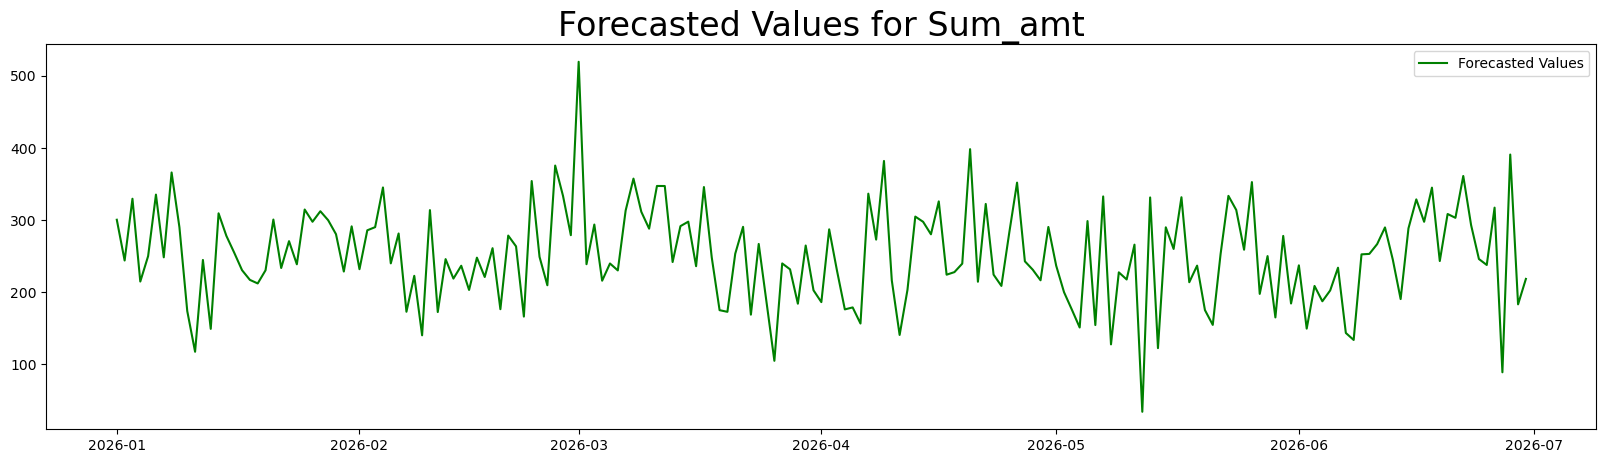

In [265]:
# Plot the forecasted values
plt.figure(figsize=(20, 5))
plt.plot(forecasts, color="green", label="Forecasted Values")
plt.title("Forecasted Values for Sum_amt", size=24)
plt.legend()
plt.show()

In [266]:
forecasts = pd.DataFrame(forecast_values.values,index=df_forecast.index,columns=['Forecast_values'])

In [267]:
forecasts

,Forecast_values
2026-01-01,300.571924
2026-01-02,244.118184
2026-01-03,329.672470
2026-01-04,214.924044
2026-01-05,250.141894
...,...
2026-06-26,317.346675
2026-06-27,89.198603
2026-06-28,390.901157
2026-06-29,183.319855


<Axes: xlabel='fin_trans_dt'>

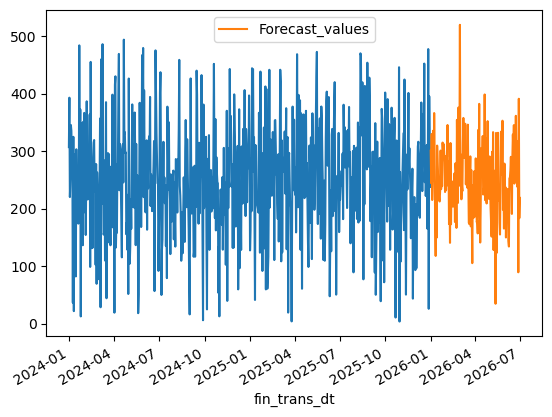

In [268]:
ax=df['Mean_amt'].plot()
forecasts.plot(ax=ax)

(20422.0, 20634.0)

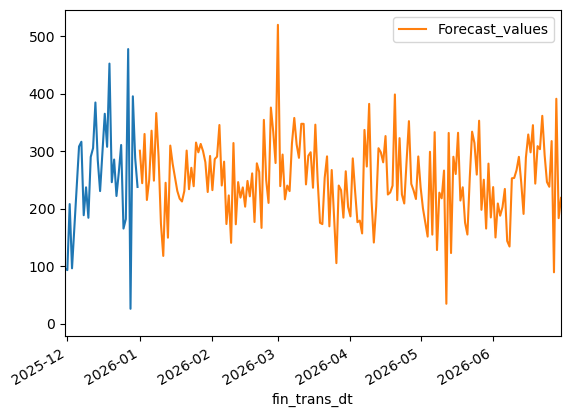

In [269]:
ax=df['Mean_amt'].plot()
forecasts.plot(ax=ax)
plt.xlim('2025-11-30','2026-06-30')

In [272]:
df_forecast.head(40)

,day_of_week,month,quarter,lag_1,lag_7,lag_20,lag_40,lag_60,rolling_mean_7,rolling_mean_30,rolling_mean_60
2026-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2026-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [273]:
df_train.head(30)

,Mean_amt,day_of_week,month,quarter,year,lag_1,lag_7,lag_20,lag_40,lag_60,rolling_mean_7,rolling_mean_30,rolling_mean_60
fin_trans_dt,,,,,,,,,,,,,
2024-01-01,306.885000,0,1,1,2024,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0
2024-01-02,392.782000,1,1,1,2024,306.885000,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0
2024-01-03,220.038000,2,1,1,2024,392.782000,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0
2024-01-04,251.850000,3,1,1,2024,220.038000,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0
2024-01-05,345.276667,4,1,1,2024,251.850000,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0
2024-01-06,335.325000,5,1,1,2024,345.276667,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0
2024-01-07,288.320000,6,1,1,2024,335.325000,0.000000,0.000000,0.0,0.0,305.782381,0.0000,0.0
2024-01-08,298.645000,0,1,1,2024,288.320000,306.885000,0.000000,0.0,0.0,304.605238,0.0000,0.0
2024-01-09,36.360000,1,1,1,2024,298.645000,392.782000,0.000000,0.0,0.0,253.687810,0.0000,0.0


In [274]:
forecasts


,Forecast_values
2026-01-01,300.571924
2026-01-02,244.118184
2026-01-03,329.672470
2026-01-04,214.924044
2026-01-05,250.141894
...,...
2026-06-26,317.346675
2026-06-27,89.198603
2026-06-28,390.901157
2026-06-29,183.319855
